# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import re
from textwrap import wrap
from string import punctuation
import os

import matplotlib.pyplot as plt
import seaborn as sns

import pickle
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import Sequence, to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, Reshape, Embedding, concatenate, LSTM, Dropout, add
from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam

# Defining global Variables

In [2]:
# Defining global Variables
IMAGE_PATH = '/kaggle/input/flickr8k/Images'
CAPTION_PATH = '/kaggle/input/flickr8k/captions.txt'

## Define Maxnim caption length based on distribution graph
MAXIMUM_CAPTION_LENGTH = 25

pd.set_option('display.expand_frame_repr', False)

# Understanding Data

In [3]:
## Read captions data
data = pd.read_csv(CAPTION_PATH)
## Sample captions data 
print(f"Sample Data :- \n{data.head()}")

print(f"\nSize of the data :- {data.shape[0]}")
print(f"\nUnique Images :- {data.image.nunique()}")

Sample Data :- 
                       image                                            caption
0  1000268201_693b08cb0e.jpg  A child in a pink dress is climbing up a set o...
1  1000268201_693b08cb0e.jpg              A girl going into a wooden building .
2  1000268201_693b08cb0e.jpg   A little girl climbing into a wooden playhouse .
3  1000268201_693b08cb0e.jpg  A little girl climbing the stairs to her playh...
4  1000268201_693b08cb0e.jpg  A little girl in a pink dress going into a woo...

Size of the data :- 40455

Unique Images :- 8091


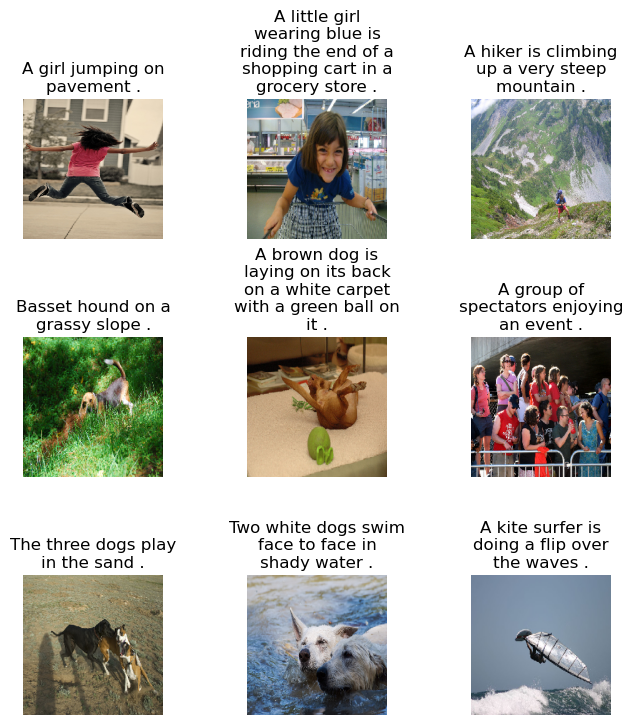

In [4]:
# To read and display Image data
def read_img(path, img_size=224):
    img = load_img(path, color_mode='rgb', target_size=(img_size, img_size))
    img = img_to_array(img)
    img = img/255
    return img 

def display_images(temp_df, num_images):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (8,8))
    n = 0
    
    for i in range(num_images):
        n += 1
        plt.subplot(3, 3, n)
        plt.subplots_adjust(hspace=0.7, wspace=0.3)
        path = IMAGE_PATH + '/' + temp_df.image[i]
        image = read_img(path)
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis('off')

        
## Display sample image with associated captions 
display_images(data.sample(9), 9)

# Preprocessing

## Text Preprocessing

In [5]:
def clean_captions(caption):
    caption = caption.lower()
    
    ## removing numbers
    number_pattern = '\d+'
    caption = re.sub(pattern=number_pattern, repl=" ", string=caption)
    
    ## Removing punctuation
    caption = caption.translate(str.maketrans('', '', punctuation))
    
    ## Removing Single Character
    single_char_pattern = r'\s+[a-zA-Z]\s+'
    caption = re.sub(pattern = single_char_pattern, repl=" ", string=caption)
    
    ## Removing Extra Spaces y
    space_pattern = r'\s+'
    caption = re.sub(pattern=space_pattern, repl=" ", string=caption)
    
    ## Add start and end tags 
    caption = 'startseq ' + caption + ' endseq'
    
    return caption

## applying text preprocessing functions on caption column
data.caption = data.caption.apply(clean_captions)

print(f"Sample data After Text Preprocessing :- \n{data.head()}")

Sample data After Text Preprocessing :- 
                       image                                            caption
0  1000268201_693b08cb0e.jpg  startseq a child in pink dress is climbing up ...
1  1000268201_693b08cb0e.jpg  startseq a girl going into wooden building  en...
2  1000268201_693b08cb0e.jpg  startseq a little girl climbing into wooden pl...
3  1000268201_693b08cb0e.jpg  startseq a little girl climbing the stairs to ...
4  1000268201_693b08cb0e.jpg  startseq a little girl in pink dress going int...


# Tokenization

In [6]:
## Get list of captions 
captions = data.caption.tolist()

## Create Tokenization object and applied on captions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
VOCAB_SIZE = len(tokenizer.word_index) + 1

## Findout maximun length of the caption text
caption_lens = [len(caption.split()) for caption in captions]
max_caption = max(caption_lens)
print(f"Maximum Caption length :- {max_caption}")

Maximum Caption length :- 34


In [7]:
## Split data into train and test datasets
images = data.image.unique().tolist()
num_images = len(images)
split_index = round(0.85*num_images)
train_images = images[:split_index]
test_images = images[split_index:]

train_data = data[data['image'].isin(train_images)].reset_index(drop=True)
test_data = data[data['image'].isin(test_images)].reset_index(drop=True)

# Image Feature Extractions

In [8]:
dense_model = DenseNet201()
img_model = Model(inputs=dense_model.input, outputs=dense_model.layers[-2].output)

img_size = 224
features = {}

for image_name in images:
    path = IMAGE_PATH + '/' + image_name
    img = load_img(path,target_size = (img_size,img_size))
    img = img_to_array(img)
    img = img/255
    img = np.expand_dims(img, axis=0)
    img_fearure = img_model.predict(img, verbose=0)
    features[image_name] = img_fearure  

82524592/82524592 [==============================] - 0s 0us/step


# Create wordembeddings for Caption words 

In [9]:
## download word embedding glove 
!wget http://nlp.stanford.edu/data/glove.6B.zip
## Unzip glove word embedding file 
!unzip /kaggle/working/glove.6B.zip -d "Glove"

--2023-04-05 19:31:23--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-04-05 19:31:23--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-04-05 19:31:23--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [10]:
## Creating dictionary with glove words & vector values
glove_embedding = {}

with open('/kaggle/working/Glove/glove.6B.200d.txt') as glove_file:
    for line in glove_file:
        values = line.split()
        word = values[0]
        word_vector = np.asarray(values[1:], 'float32')
        glove_embedding[word] = word_vector

glove_file.close()

## Define global variables 
EMBED_DIM = 200

## Creating a embedding matrix for caption words using glove wordembedding matrix
embedding_matrix = np.zeros((VOCAB_SIZE, 256))
zero_array = [0]*56

for i, word in tokenizer.index_word.items():
    if i < VOCAB_SIZE:
        vector = glove_embedding.get(word)
        if vector is not None:
            embedding_matrix[i] = np.concatenate((vector, zero_array))

In [11]:
class CustomDataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features,shuffle=True):
    
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self,index):
    
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)        
        return (X1, X2), y
    
    def __get_data(self,batch):
        
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[image][0]
            
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
        return X1, X2, y

# Define CNN-LSTM model 

In [12]:
## define input layer for images & captions 
img_input_layer = Input(shape=(1920,))
caption_input_layer = Input(shape=(MAXIMUM_CAPTION_LENGTH,))

## Define layers to extract features from images and captions 

## Feature extraction layers for image
img_features_layer = Dense(256, activation='relu')(img_input_layer)
img_features_reshaped_layer = Reshape((1, 256), input_shape=(256,))(img_features_layer)

## Feature extraction layers for Captions
caption_features_layer = Embedding(input_dim = VOCAB_SIZE,
                            output_dim = 256,
                            embeddings_initializer = Constant(embedding_matrix),
                            input_length = MAXIMUM_CAPTION_LENGTH,
                            trainable = False)(caption_input_layer)

combined_layers = concatenate([img_features_reshaped_layer, caption_features_layer], axis=1)
caption_features_layer = LSTM(256)(combined_layers)
x = Dropout(0.5)(caption_features_layer)
x = add([x, img_features_layer])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(VOCAB_SIZE, activation='softmax')(x)

caption_model = Model(inputs=[img_input_layer,caption_input_layer], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')


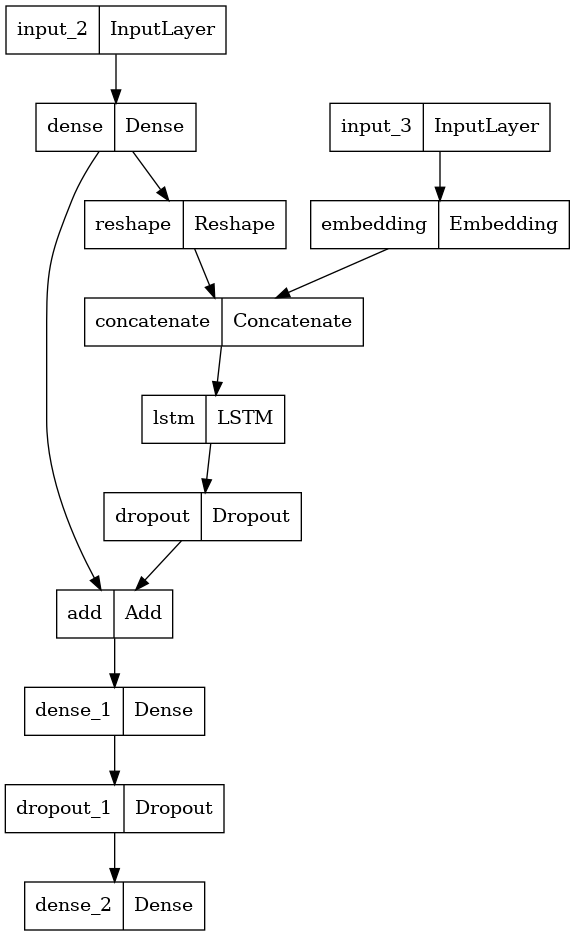

In [13]:
plot_model(caption_model)

In [14]:
caption_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1920)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 256)          491776      ['input_2[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 25)]         0           []                               
                                                                                                  
 reshape (Reshape)              (None, 1, 256)       0           ['dense[0][0]']                  
                                                                                            

In [15]:
## Create train and validation data generators to create batchwise data
train_generator = CustomDataGenerator(df = train_data,
                                      X_col = 'image',
                                      y_col = 'caption',
                                      batch_size = 64,
                                      directory = IMAGE_PATH,
                                      tokenizer = tokenizer,
                                      vocab_size = VOCAB_SIZE,
                                      max_length = MAXIMUM_CAPTION_LENGTH,
                                      features = features)

validation_generator = CustomDataGenerator(df = test_data,
                                           X_col = 'image',
                                           y_col = 'caption',
                                           batch_size = 64,
                                           directory = IMAGE_PATH,
                                           tokenizer = tokenizer,
                                           vocab_size = VOCAB_SIZE,
                                           max_length = MAXIMUM_CAPTION_LENGTH,
                                           features = features)

In [16]:
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)

# Train model

In [17]:
history = caption_model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/50
537/537 [==============================] - ETA: 0s - loss: 4.8421
Epoch 1: val_loss improved from inf to 4.05928, saving model to model.h5
537/537 [==============================] - 257s 468ms/step - loss: 4.8421 - val_loss: 4.0593 - lr: 0.0010
Epoch 2/50
537/537 [==============================] - ETA: 0s - loss: 4.0198
Epoch 2: val_loss improved from 4.05928 to 3.75663, saving model to model.h5
537/537 [==============================] - 51s 96ms/step - loss: 4.0198 - val_loss: 3.7566 - lr: 0.0010
Epoch 3/50
537/537 [==============================] - ETA: 0s - loss: 3.7920
Epoch 3: val_loss improved from 3.75663 to 3.61031, saving model to model.h5
537/537 [==============================] - 54s 100ms/step - loss: 3.7920 - val_loss: 3.6103 - lr: 0.0010
Epoch 4/50
537/537 [==============================] - ETA: 0s - loss: 3.6481
Epoch 4: val_loss improved from 3.61031 to 3.53646, saving model to model.h5
537/537 [==============================] - 54s 101ms/step - loss: 3.6481 

In [18]:
#pickling the model
pickle.dump(caption_model, open('/kaggle/working/captionGenerator.sav', 'wb'))

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......add
.........vars
......concatenate
.........vars
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......embedding
.........vars
............0
......input_layer
.........vars
......input_layer_1
.........vars
......lstm
.........cell
............vars
...............0
...............1
...............2
.........vars
......reshape
.........vars
...metrics
......mean
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........17
.........18
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Mod

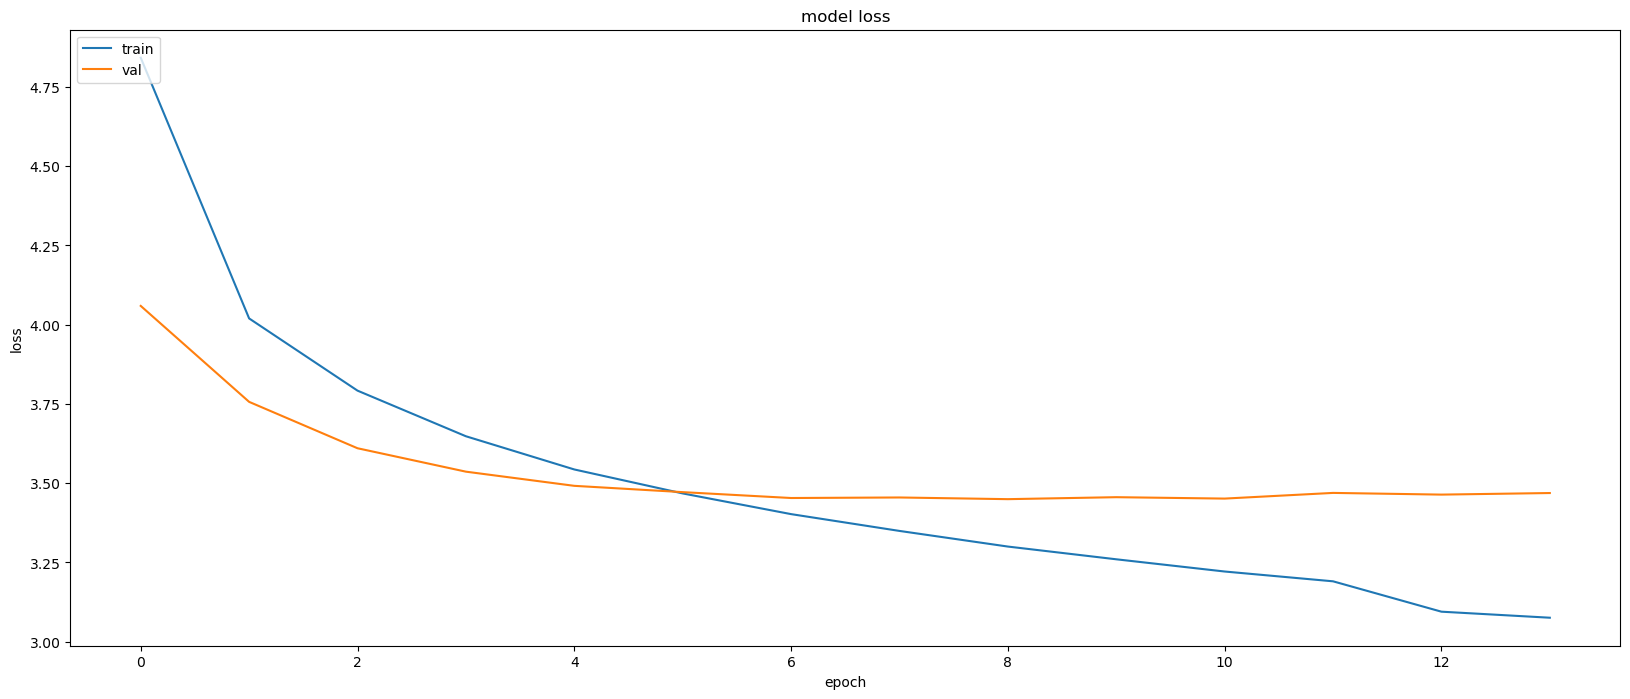

In [19]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Prediction

In [20]:
def idx_to_word(integer,tokenizer):
    
    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None


def predict_caption(model, image, tokenizer, max_length, features):
    
    feature = features[image]
    in_text = ""
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)
        
        word = idx_to_word(y_pred, tokenizer)
        
        if word is None:
            break
            
        if word != 'startseq' and word != 'endseq':
            in_text += " " + word
        
        if word == 'endseq':
            break
            
    return in_text 

In [21]:
samples = test_data.sample(15)
samples.reset_index(drop=True,inplace=True)

for index,record in samples.iterrows():

    img = load_img(IMAGE_PATH + '/' + record['image'],target_size=(224,224))
    img = img_to_array(img)
    img = img/255.
    
    caption = predict_caption(caption_model, record['image'], tokenizer, MAXIMUM_CAPTION_LENGTH, features)
    samples.loc[index,'caption'] = caption

1/1 [==============================] - 0s 21ms/step


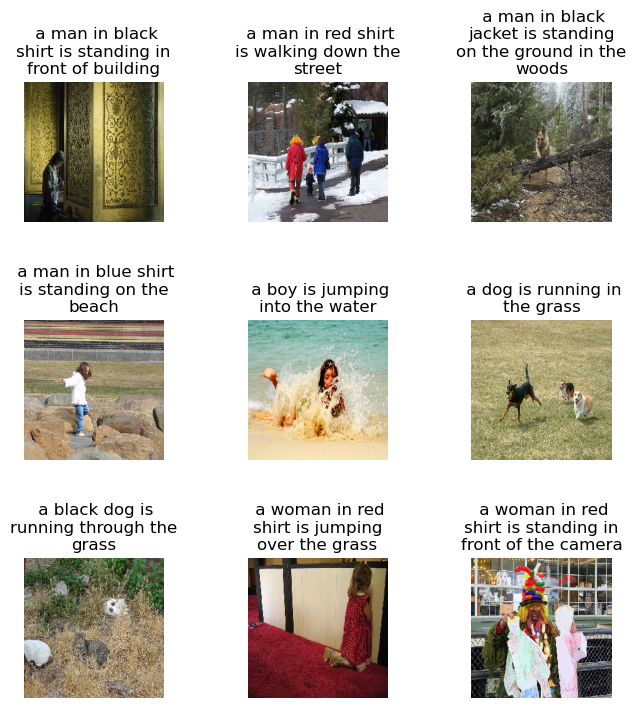

In [22]:
display_images(samples, 9)

In [23]:
from nltk.translate.bleu_score import corpus_bleu

# Collect reference captions for each image in the test set
references = []
for index, record in samples.iterrows():
    refs = []
    for ref in record['caption']:
        refs.append(ref.split())
    references.append(refs)

# Collect generated captions for each image in the test set
hypotheses = []
for index, record in samples.iterrows():
    hypotheses.append(record['caption'].split())

# Calculate BLEU score
weights = (0.25, 0.25, 0.25, 0.25)  # equal weights for 1-4 grams
bleu_score = corpus_bleu(references, hypotheses, weights=weights)

print("BLEU score: {:.4f}".format(bleu_score))

BLEU score: 0.5721


/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
